# Simulation of Haber-Bosch process in a fixed bed reactor.

Haber-Bosch process involves the conversion of $N_{2}$ and $H_{2}$ to $NH_{3}$ through a magnetite assisted ($Fe_{3}O_{4}@K$) catalyst, balances of mass and energy are vital to understand the behavior of the process, and study the influence of different parameters on the process.

### Mass balance

$$
\frac{dX}{dL} = \frac{R_{NH_{3}}\cdot \eta \cdot A_{reactor}}{2F_{N_{2}}}
$$

### Energy balance

$$
\frac{dT}{dL} = \frac{-\Delta_{r}H\cdot \eta \cdot R_{NH_{3}}}{F_{total}\cdot C_{p, mix}}
$$

### Total molar flowrate
$$
F_{total} = u\cdot C \cdot A
$$

where $u$ is the velocity flow measured as $m\cdot h^{-1}$, $C$ is the concentration of reactant measured in $kmol \cdot m^{-3}$, and $A$ is the area of the reactor measured in $m^2$, molar flow units $F$ are given in $kmol\cdot h^{-1}$.

### Ammonia rate production

$$
R_{NH_{3}} = 2k \left( K^2_{eq}\cdot a_{N_{2}}\left[ \frac{a^3_{H_{2}}}{a^2_{NH_{3}}}\right]^{\alpha} - \left[ \frac{a^2_{NH_{3}}}{a^3_{H_{2}}}\right]^{1-\alpha} \right)
$$

#### Gas activities

$$
a_{x} = y_{x}\cdot \phi_{x}\cdot P
$$

#### Kinetic constant

From Arrhenius

$$
k = k_{0}\cdot e^{-E_{a}/RT}
$$

### Equilibria constant

$$
log \ K_{eq} = -2.792312\cdot logT - 5.527463\cdot 10^{-5}T + 1.837742\cdot 10^{-5}T^2 + \frac{2002.4}{T} + 2.799
$$

### Fugacities

$$
(1) \ \phi_{N_2} = 0.94231827 + 0.2129547 \times 10^{-3} T + 28678509 \times 10^{-3} P - 0.280826 \times 10^{-6} T^2 + 0.4886308 \times 10^{-6} P^2
$$

$$
(2) \ \phi_{H_2} = \exp \left\{ \exp \left( -3.7301 T^{0.125} + 0.543 \right) \times P - \exp \left( -0.1374 T^{0.5} - 16.99 \right) \times P^2 + 314 \times \exp \left( -0.02291 T - 5.943 \right) \times \exp \left( -\frac{P}{300} \right) \right\}
$$

$$
(3) \ \phi_{NH_{3}} = 0.1327886 + 0.3038548 \times 10^{-2} T - 0.4397572 \times 10^{-3} P - 0.1233954 \times 10^{-5} T^2 + 0.2851314 \times 10^{-6} P^2
$$

### Molar fraction

$$
y_{x} = \frac{n_{x}}{\sum_{1}^{i}{n_{i}}}
$$

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from sympy import solve, nsolve, symbols, expand, latex
from sympy.abc import x
import matplotlib.pyplot as plt

In [3]:
def flow_rate(u, c, area):
    # Returns flow rate based on initial reagent concentration, velocity flow, and reactor area
    # Area is the parameter to iterate for this analysis.
    return (u * c * area)

In [4]:
def mass_balance(area_r, r_ammonia, eta, u, c_0):
    # Define flow rate
    f_n = flow_rate(u, c_0, area_r)
    
    # Define ordinary differential equation
    return (r_ammonia * eta * area_r / 2 * f_n)

In [5]:
def energy_balance(area_r, r_ammonia, enthalpy, eta, u, c_0, cp_mix):
    # Define flow rate
    f_t = flow_rate(u, c_0, area_r)
    
    # Define ordinary differential equation
    return (-enthalpy * eta * r_ammonia / f_t * cp_mix)

In [6]:
def ammonia_rate(k, k_eq, a_n2, a_h2, a_nh3, alpha):
    # Returns ammonia rate
    r_ammonia = 2 * k * (k_eq**2 * a_n2 * (a_h2**3 / a_nh3**2)**alpha - (a_nh3**2 / a_h2**3)**(1-alpha))

    return r_ammonia

In [7]:
def molar_fraction(i, reagents):
    # Returns molar fraction
    y = reagents[i] / sum(reagents.values())
    return y

In [8]:
def fugacities(T, P): # Units probably do not match these empirical formulas.
    # Returns fugacity of hydrogen
    phi_h2 = np.exp(np.exp(-3.7301 * T**0.125 + 0.543) * P - np.exp(-0.1374 * T**0.5 - 16.99) * P**2 + 314 * np.exp(-0.02291 * T - 5.943) * np.exp(-P/300))
    
    # Returns fugacity of nitrogen
    phi_n2 = 0.94231827 + 0.2129547 * 10**(-3) * T + 28678509 * 10**(-3) * P - 0.280826 * 10**(-6) * T**2 + 0.4886308 * 10**(-6) * P**2

    # Returns fugacity of ammonia
    phi_nh3 = 0.1327886 + 0.3038548 * 10**(-2) * T - 0.4397572 * 10**(-3) * P - 0.1233954 * 10**(-5) * T**2 + 0.2851314 * 10**(-6) * P**2
    
    return (phi_h2, phi_n2, phi_nh3)

In [9]:
def activities(T, P, reagents):
    # Returns activities based on fugacities, operational pressure and molar fraction
    a_h2 = fugacities(T, P)[0] * molar_fraction('H_2', reagents)
    a_n2 = fugacities(T, P)[1] * molar_fraction('N_2', reagents)
    a_nh3 = fugacities(T, P)[2] * molar_fraction('NH_3', reagents)
    return (a_h2, a_n2, a_nh3)

In [10]:
def arrhenius(T):
    # Returns velocity rate constant according to Arrhenius
    k_0 = 8.85e14
    e_a = 170550 # kJ/kmol
    R = 8.314 # kJ/(kmol*K)
    k = k_0 * np.exp(-e_a/R*T)
    return k

In [11]:
def equilibrium_constant(T_exp):
    # Returns equilibria constant
    # k_eq = -2.792312 * np.log(T) - 5.527463 * 10**(-5) * T + 1.837742 * 10**(-5) * T**2 + 2002.4 / T + 2.799 # No convergence
    
    # Standard values
    delta_H_std = -92.22 # kJ/mol
    delta_gibbs_std = -32.8 # kJ/mol*K
    R = 8.314 # J/(mol*K)
    T = 298.15 # K
    k_eq_std = np.exp((-delta_gibbs_std*1000) / (T*R)) # Equilibria constant at SATP

    # Equilibria constant based on Van't Hoff equation
    v_hoff = (-1000*delta_H_std / R) * ((1/T) - (1/T_exp))
    k_eq = k_eq_std * np.exp(v_hoff)
    return k_eq

In [12]:
def catalyst_eff(T, X=1):

    coefficients = {
    "b0": -8.21,
    "b1": 0.038,
    "b2": 6.19,
    "b3": -5.35,
    "b4": -20.8,
    "b5": 2.38e-8,  # Using scientific notation for 2.38 × 10^-8
    "b6": 27.9
    }

    eta = (
    coefficients["b0"] +
    coefficients["b1"] * T +
    coefficients["b2"] * X +
    coefficients["b3"] * T**2 +
    coefficients["b4"] * X**2 +
    coefficients["b5"] * T**3 +
    coefficients["b6"] * X**3
    )

    return eta

Considering a reaction held at Haber-Bosch conditions of T = 723.15 K, P = 33.4 MPa, and $C_{N_{2}} = 20.0$, $C_{H_{2}} = 60.0$ in units of $kmol\cdot m^{-3}$. Operational flow conditions include an inert gas stream of Ar at a speed flow of 100 $m\cdot h^{-1}$.

In [13]:
f_n = flow_rate(u=100, c=20, area=1) # Area has to be iterated to check performance
print(f"Molar flow rate of nitrogen gas: {f_n} kmol/h")

Molar flow rate of nitrogen gas: 2000 kmol/h


In [14]:
reagents = {'H_2': 60, 'N_2': 20, 'NH_3': 1e-10}

## Equilibria expression for Haber-Bosch process

$$
\begin{align*}
3H_{2} \ + N_{2} \ \rightleftharpoons \ 2NH_{3} \\
\ 600 \ \ \ \ \ \  200 \ \ \ \ \ \ \ \ 0 \ \ \ \ \ \ \ \ \ \\
\ 600-3x \ \ \ \   200-x \ \ \  \  +2x 
\end{align*}
$$

$$
K_{eq} = \frac { \left[ a^2_{NH_{3}} \right] } { \left[ a^3_{H_{2}} \right] \left[ a_{N_{2}}\right] }
$$

$$
K_{eq} = \frac { \left( 2x \right)^2 } { \left( 600-3x \right)^3 \left( 200-x \right) }
$$

In [15]:
# Consider to use latexify library # THIS IS NOT A SUBLIMINAL MESSAGE 👽🛸👾
# Using SymPy to delve into the polynomial
x, k_eq, H_2, N_2, NH_3 = symbols("x k_eq H_2 N_2 NH_3")
k_eq_pol = k_eq*((H_2 - 3*x)**3*(N_2 - x)) - 4*x**4

### Polynomial to solve:
$$
H_{2}^{3} N_{2} k_{eq} - H_{2}^{3} k_{eq} x - 9 H_{2}^{2} N_{2} k_{eq} x + 9 H_{2}^{2} k_{eq} x^{2} + 27 H_{2} N_{2} k_{eq} x^{2} - 27 H_{2} k_{eq} x^{3} - 27 N_{2} k_{eq} x^{3} + 27 k_{eq} x^{4} - 4 x^{4}
$$


### Defining equilibria constant:

`T = 723.15 K`, `P = 33.4 MPa`, $C_{N_{2}} = 200.0$, $C_{H_{2}} = 600.0$

In [16]:
k_eq_t = equilibrium_constant(400.15)
print(k_eq_t)

7330918641.510444


In [17]:
sub_replace = {
    "H_2": 600, # Number of kmol/m^3 for H2
    "N_2": 200, # Number of kmol/m^3 for N2
    "k_eq": k_eq_t # Equilibrium constant
}

# Equilibria polynomial
updated_pol = k_eq_pol.subs(sub_replace)
print(expand(updated_pol))

197934803316.782*x**4 - 158347842656626.0*x**3 + 4.75043527969877e+16*x**2 - 6.33391370626502e+18*x + 3.16695685313251e+20


In [18]:
x = symbols('x')
solutions = solve(updated_pol, x)

In [19]:
solutions = [x.evalf() for x in solutions]
solutions

[199.576849732283,
 200.424948438171,
 199.999100922857 - 0.424045540413262*I,
 199.999100922857 + 0.424045540413262*I]

In [20]:
y_solutions = []
for value in range(0, 250):
    try:
        y_solutions.append(nsolve(updated_pol, x, value))
    except ValueError:
        pass

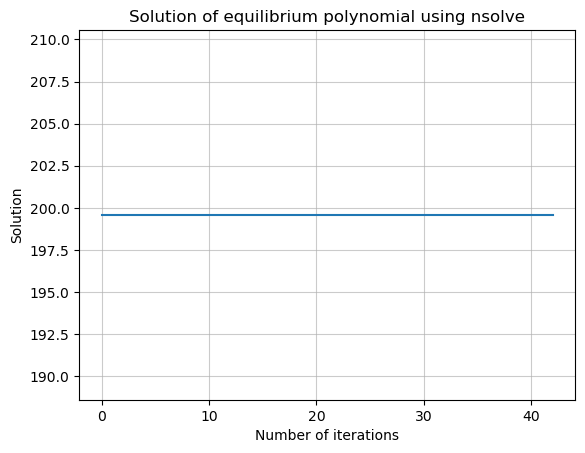

In [21]:
plt.plot(range(0, len(y_solutions)), y_solutions)
plt.xlabel("Number of iterations")
plt.ylabel("Solution")
plt.title("Solution of equilibrium polynomial using nsolve")
plt.grid(alpha=0.66)
plt.show()

In [22]:
NH_3 = 2*solutions[0]
N_2 = sub_replace["N_2"] - solutions[0]
H_2 = sub_replace["H_2"] - 3*solutions[0]
print(f"Concentration of NH3 in the equilibrium solution is: {NH_3:.2f} kmol/m^3")
print(f"Concentration of N2 in the equilibrium solution is: {N_2:.2f} kmol/m^3")
print(f"Concentration of H2 in the equilibrium solution is: {H_2:.2f} kmol/m^3")

# Updating reagents dictionary
reagents_eq = {'H_2': H_2, 'N_2': N_2, 'NH_3': NH_3}
reagents_eq

Concentration of NH3 in the equilibrium solution is: 399.15 kmol/m^3
Concentration of N2 in the equilibrium solution is: 0.42 kmol/m^3
Concentration of H2 in the equilibrium solution is: 1.27 kmol/m^3


{'H_2': 1.26945080315159, 'N_2': 0.423150267717176, 'NH_3': 399.153699464566}

In [23]:
# It is neccesary to use solver for estimating NH3 equilibrium concentration.
yi_NH_3 = molar_fraction('NH_3', reagents)
y_NH_3 = molar_fraction('NH_3', reagents_eq)
print(f"NH3 molar fraction in the equilibrium at initial conditions: {yi_NH_3:.2f}")
print(f"NH3 molar fraction in the equilibrium at initial conditions: {y_NH_3:.2f}")

NH3 molar fraction in the equilibrium at initial conditions: 0.00
NH3 molar fraction in the equilibrium at initial conditions: 1.00


Equation solution using `solve` is retrieving same value, I will iterate over a range of numbers to find a different solution.

In [24]:
eq_t = np.linspace(298.15, 800, 1000)

In [25]:
temp_pols = [
    k_eq_pol.subs(
    {
        "H_2": 600, # Number of kmol/m^3 for H2.
        "N_2": 200, # Number of kmol/m^3 for N2.
        "k_eq": new_k_eq # Equilibrium constant depending on range from 298.15 K to 800 K temperatures.
    }
    ).evalf()

    for new_k_eq in eq_t
]

temp_sols = [
    solve( # Solving the polynomial
    temp_pol, 
    x
    )
    for temp_pol in temp_pols
]

$$
t = \frac{P\cdot D}{2S\cdot F \cdot E \cdot T}
$$

In [ ]:
temp_sols = np.array(temp_sols)

In [ ]:
matrix_rows = []
for idx, key in enumerate(temp_sols):
    NH_3 = 2*key[0]
    N_2 = 200 - key[0]
    H_2 = 600 - 3*key[0]

    matrix_rows.append([H_2, N_2, NH_3])

reagents_eq_temp = np.array(matrix_rows)

# Ammonia molar fraction
y_NH_3_temp = np.array([reagents_eq_temp[x, 2] / np.sum(reagents_eq_temp[x, :]) for x in range(0, len(reagents_eq_temp))])
# Nitrogen molar fraction
y_N_2_temp = np.array([reagents_eq_temp[x, 1] / np.sum(reagents_eq_temp[x, :]) for x in range(0, len(reagents_eq_temp))])
# Hydrogen molar fraction
y_H_2_temp = np.array([reagents_eq_temp[x, 0] / np.sum(reagents_eq_temp[x, :]) for x in range(0, len(reagents_eq_temp))])

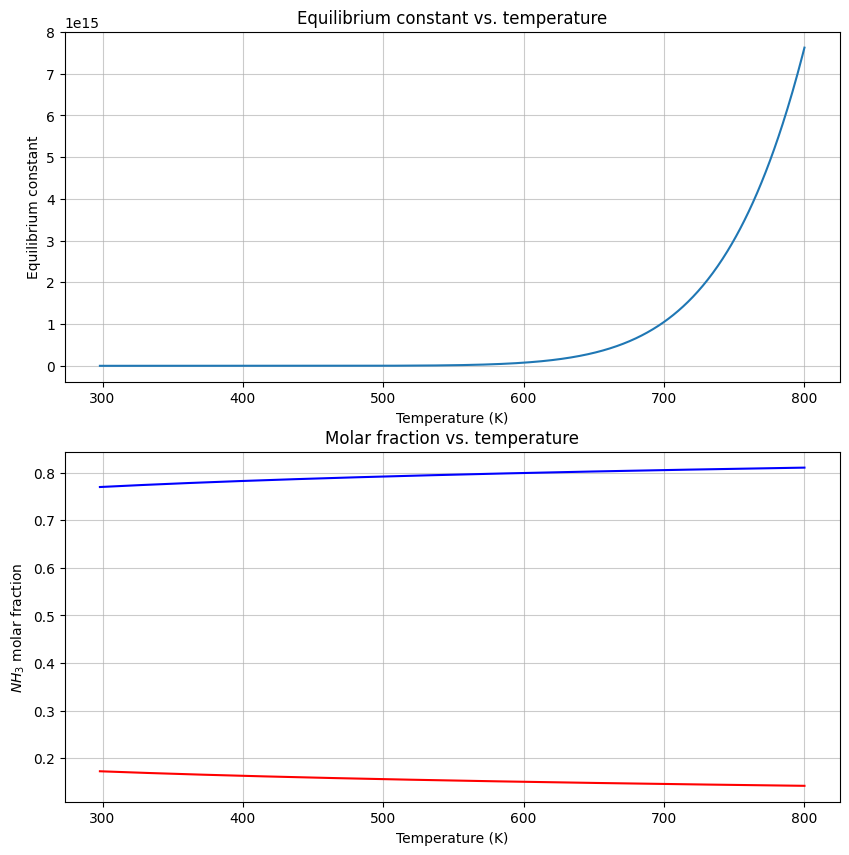

In [ ]:
x_temperature = np.linspace(
    start=298.15,
    stop=800,
    num=1000
)

eq_t = equilibrium_constant(x_temperature) # Dependence of equilibria constant on temperature

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(x_temperature, eq_t)
ax[0].set_xlabel("Temperature (K)")
ax[0].set_ylabel("Equilibrium constant")
ax[0].set_title("Equilibrium constant vs. temperature")
ax[0].grid(alpha=0.66)

ax[1].plot(x_temperature, y_NH_3_temp, color = "blue")
ax[1].plot(x_temperature, y_H_2_temp, color = "red")
ax[1].set_xlabel("Temperature (K)")
ax[1].set_ylabel(r"$NH_{3}$ molar fraction")
ax[1].set_title("Molar fraction vs. temperature")
ax[1].grid(alpha=0.66)

plt.show()

In [ ]:
# Kinetic constant
k = arrhenius(T=723.15)
k # This constant should not be 0.0, despite ammonia synthesis kinetics are slow, 
#in addition, k should exhibit a higher value when T increase

0.0

In [ ]:
# Equilibrium constant
k_eq = equilibrium_constant(T_exp=723.15)

# Fugacities
fug = fugacities(T=723.15, P=33.4)
fug_dict = {
    "H2" : fug[0],
    "N2" : fug[1], # Observe this fugacity.
    "NH3" : fug[2]
}

In [ ]:
a_h2, a_n2, a_nh3 = activities(T=723.15, P=33.4, reagents=reagents_eq)

# def ammonia_rate(k, k_eq, a_n2, a_h2, a_nh3, alpha):
#     # Returns ammonia rate
#     r_ammonia = 2 * k * (k_eq**2 * a_n2 * (a_h2**3 / a_nh3**2)**alpha - (a_nh3**2 / a_h2**3)**(1-alpha))

#     return r_ammonia

# Ammonia rate
ammonia_rate = ammonia_rate(1e-2, k_eq, a_h2, a_n2, a_nh3, 0.5)
print(ammonia_rate)

3.78086958690321e+30


In [ ]:
print(f"Ln Keq is equal to: {np.log(k_eq):.2f}")
print(f"Activities are: Hydrogen: {a_h2:.2f}, Nitrogen: {a_n2:.2f}, Ammonia: {a_nh3:.2f}")
print(f"Kinetic constant is equal to: {k:.2f}")
print(f"Molar fractions in the equilibrium are: of NH3 {y_NH_3:.2f}, of N2: {y_N_2:.2f}, of H2: {y_H_2:.2f}")

Ln Keq is equal to: 35.10
Activities are: Hydrogen: 0.00, Nitrogen: 1011.16, Ammonia: 1.66
Kinetic constant is equal to: 0.00


NameError: name 'y_N_2' is not defined

In [ ]:
k_provisional = 1e-5
result = 2 * k_provisional * (k_eq**2 * a_n2 * (a_h2**3 / a_nh3**2)**0.5 - (a_nh3**2 / a_h2**3)**(1-0.5))
print(result)

6.73061834754534e+24


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=344a9c6a-e748-4639-9ec7-4bd1ce80f8d6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>